In [1]:
import sys; sys.path.insert(0, '../../external/')

%run ../initlibs.py cryptomomentum dark
from models.research_utils import load_data
from sklearn.base import TransformerMixin
from sklearn.pipeline import make_pipeline


import ira
%alphalab

from alpha.utils.data_helpers import FriendlyFxLoader

Reloaded ../../external/ira/experimental/c_simulator_core.pyx


In [2]:
from qlearn.tracking.trackers import Tracker, TakeStopTracker
from qlearn.core.base import BasicMarketEstimator, MarketDataComposer
from qlearn.core.pickers import SingleInstrumentPicker

In [3]:
data = ohlc_resample(load_data('BTCUSDT'), '5Min')

We will use new framework (QLearn) for development this model as it should give us more flexible approach to 
testing mixed models.
<hr/>

In [4]:
class RollingRange(TransformerMixin):
    """
    Produces range top/bottom measures on rolling base
    """
    def __init__(self, timeframe, period, tz='UTC'):
        self.period = period
        self.timeframe = timeframe
        self.tz = tz
    
    def fit(self, x, **kwargs):
        return self
    
    def transform(self, x):
        ohlc = ohlc_resample(x, self.timeframe, resample_tz=self.tz)
        hilo = scols(
            ohlc.rolling(self.period, min_periods=self.period).high.apply(lambda x: max(x)),
            ohlc.rolling(self.period, min_periods=self.period).low.apply(lambda x: min(x)),
            names=['RangeTop', 'RangeBot'])
        hilo.index = hilo.index + pd.Timedelta(self.timeframe)
        hilo = ohlc.combine_first(hilo).fillna(method='ffill')[hilo.columns]
        return x.assign(RangeTop = hilo.RangeTop, RangeBot = hilo.RangeBot)
    

class RangeBreakoutDetector(BasicMarketEstimator):
    def fit(self, X, y, **fit_params):
        return self

    def predict(self, X):
        meta = self.metadata()
        hilo = X[['RangeTop', 'RangeBot']]
        
        ohlc = X.shift(1)
        d_1 = ohlc.shift(1)[['open', 'close']].rename(columns={'open': 'open_1', 'close': 'close_1'})
        t = pd.concat((ohlc[['open', 'close']], d_1, hilo), axis=1)
        t.fillna(method='ffill', inplace=True)
        sigs = srows(
            pd.Series(+1, t[(t.open_1 < t.RangeTop) & (t.close_1 < t.RangeTop) & (t.close > t.RangeTop)].index),
            pd.Series(-1, t[(t.open_1 > t.RangeBot) & (t.close_1 > t.RangeBot) & (t.close < t.RangeBot)].index)
        )
        return sigs

In [5]:
b_ents = MarketDataComposer(
    make_pipeline(RollingRange('1d', 55), RangeBreakoutDetector()), 
    SingleInstrumentPicker(), None)

b_exits = MarketDataComposer(
    make_pipeline(RollingRange('1d', 10), RangeBreakoutDetector()), 
    SingleInstrumentPicker(), None)

In [6]:
s = shift_signals(
    srows(
        1 * b_ents.fit(data, None).predict(data),
        2 * b_exits.fit(data, None).predict(data),
        pd.DataFrame({'BTCUSDT': 'regime:m1'}, index=pd.DatetimeIndex(['2017-10-14 15:00:00']))
    ), '4M59Sec')

In [23]:
class TurtleTracker(TakeStopTracker):
    def __init__(self, account_size, dollar_per_point, max_units=4, atr_period='1d', pull_stops_on_incr=False, after_lose_only=False, debug=False):
        super().__init__(debug)
        self.account_size = account_size 
        self.dollar_per_point = dollar_per_point
        self.atr_period = atr_period
        self.max_units = max_units
        self.trading_after_lose_only = after_lose_only
        self.pull_stops = pull_stops_on_incr 
        
    def initialize(self):
        self.days = self.get_ohlc_series(self.atr_period)
        self.N = None
        self.__TR_init_sum = 0
        self._n_entries = 0
        self._last_entry_price = np.nan
    
    def calculate_trade_size(self, direction, n, risk_capital_pct=0.01):
        return round((risk_capital_pct * self.account_size) / (n * self.dollar_per_point)) * direction
        
    def on_quote(self, quote_time, bid, ask, bid_size, ask_size, **kwargs):
        daily, n_days = self.days, len(self.days)
        today, yest = daily[1], daily[2]
        
        if yest is None or today is None:
            return
        
        if daily.is_new_bar:
            now_date = daily[0].time
            TR = max(today.high - today.low, today.high - yest.close, yest.close - today.low)
            if self.N is None:
                if n_days <= 21:
                    self.__TR_init_sum += TR
                else:
                    self.N = self.__TR_init_sum / 19
            else:
                self.N = (19 * self.N + TR) / 20
                
        # increasing position size if possible
        pos = self._position.quantity
        if pos != 0 and self._n_entries < self.max_units:
            n_2 = self.N / 2
            if (pos > 0 and ask > self._last_entry_price + n_2) or (pos < 0 and bid < self._last_entry_price - n_2):
                t_size = self.calculate_trade_size(np.sign(pos), self.N)
                self._n_entries += 1
                self._last_entry_price = ask if pos > 0 else bid
                
                # increase inventory
                self.trade(quote_time, pos + t_size)
                
                # pull stops
                if self.pull_stops:
                    self.stop_at(quote_time, self._last_entry_price - self.N * 2 * np.sign(pos))
                    
                self.debug(f"\t[{quote_time}] -> [#{self._n_entries}] N/2: {n_2:.3f} {self._instrument} increase to {pos + t_size} @ {self._last_entry_price} x {self.stop:.2f}")
        
        # call stop/take tracker to process sl/tp if need
        super().on_quote(quote_time, bid, ask, bid_size, ask_size, **kwargs)

    def on_signal(self, signal_time, signal, quote_time, bid, ask, bid_size, ask_size):
        if self.N is None:
            return None
        
        s_type, s_direction, t_size = abs(signal), np.sign(signal), None
        position = self._position.quantity
        
        # when we want to enter position
        if position == 0 and s_type == 1:
            if not self.trading_after_lose_only or self.last_triggered_event != 'stop':
                t_size = self.calculate_trade_size(s_direction, self.N)
                self._last_entry_price = ask if s_direction > 0 else bid
                self.stop_at(signal_time, self._last_entry_price - self.N * 2 * s_direction)
                self.last_triggered_event = None
                self._n_entries = 1
                self.debug(f'\t[{signal_time}] -> [#{self._n_entries}] {self._instrument} {t_size} @ {self._last_entry_price:.2f} x {self.stop:.2f}')
                
        # when we got to exit signal
        if (position > 0 and signal == -2) or (position < 0 and signal == +2):
            self.last_triggered_event = 'take'
            self._n_entries = 0
            t_size = 0
            self.debug(f'[{signal_time}] -> Close in profit {self._instrument} @ {bid if position > 0 else ask}')
            self.times_to_take.append(signal_time - self._last_trade_time)
            self.n_takes += 1
                
        return t_size

In [24]:
p = z_backtest(shift_signals(s, '4M59S'), data, 'crypto', spread=0.5, execution_logger=True, 
               trackers=TurtleTracker(1000, 0.01, max_units=4, debug=True))

	[2017-10-12 08:09:58] -> [#1] BTCUSDT 3 @ 5045.75 x 4429.51
	[2017-10-12 10:59:00] -> [#2] N/2: 154.060 BTCUSDT increase to 6 @ 5204.59 x 4896.47
	[2017-10-12 16:29:00] -> [#3] N/2: 154.060 BTCUSDT increase to 9 @ 5363.13 x 5055.01
	[2017-10-13 02:04:00] -> [#4] N/2: 162.102 BTCUSDT increase to 12 @ 5553.44 x 5229.24
 -> [2017-10-18 13:49:00] stop long [BTCUSDT] at 5224.01000
	[2017-10-20 15:19:58] -> [#1] BTCUSDT 3 @ 5986.26 x 5315.38
	[2017-10-21 14:24:00] -> [#2] N/2: 172.085 BTCUSDT increase to 6 @ 6169.13 x 5824.96
 -> [2017-10-22 04:19:00] stop long [BTCUSDT] at 5820.23000
	[2017-10-29 20:34:58] -> [#1] BTCUSDT 3 @ 6145.25 x 5451.55
	[2017-10-31 13:59:00] -> [#2] N/2: 174.851 BTCUSDT increase to 6 @ 6329.29 x 5979.59
	[2017-11-01 09:30:00] -> [#3] N/2: 176.059 BTCUSDT increase to 9 @ 6510.25 x 6158.13
	[2017-11-01 22:44:00] -> [#4] N/2: 176.059 BTCUSDT increase to 12 @ 6690.2 x 6338.08
 -> [2017-11-10 20:24:00] stop long [BTCUSDT] at 6326.32000
	[2017-11-16 19:09:58] -> [#1] BTC

Statistic,Model
Gain (USD):,251213.15
CAGR (%):,95.230
Sharpe:,1.250
Sortino:,2.267
Calmar:,1.420
MaxDD (%):,51.190
MaxDD On Init BP (%):,505.881
MaxDD (USD):,50588.070
MaxDD days:,510 days
MaxDD start:,2017-12-17

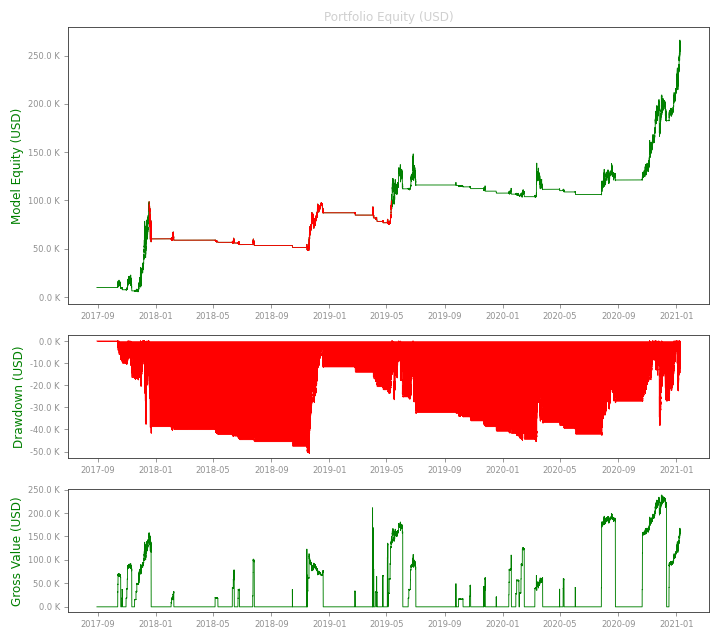

<Figure size 720x640 with 0 Axes>

In [25]:
tearsheet(p, 10000)

In [20]:
p.executions

,exec_price,instrument,quantity
2017-10-12 08:09:58,5045.75,BTCUSDT,3.0
2017-10-12 10:59:00,5204.59,BTCUSDT,3.0
2017-10-12 16:29:00,5363.13,BTCUSDT,3.0
2017-10-13 02:04:00,5553.44,BTCUSDT,3.0
2017-11-11 13:34:58,6179.75,BTCUSDT,-12.0
...,...,...,...
2020-12-11 11:44:58,17652.35,BTCUSDT,-12.0
2020-12-16 13:54:58,20331.19,BTCUSDT,1.0
2020-12-16 14:14:00,20798.60,BTCUSDT,1.0
2020-12-16 21:54:00,21267.01,BTCUSDT,1.0


In [21]:
p.trackers_stat

{'BTCUSDT': {'takes': 12,
  'stops': 12,
  'average_time_to_take': Timedelta('25 days 12:15:03.166666666'),
  'average_time_to_stop': Timedelta('2 days 22:52:35.666666666')}}